 **Introduction**



 This Python program is designed to backtest a technical analysis based algorithmic trading strategy.



 **The strategy**



The RSI (Relative Strength Index) trading strategy is a momentum oscillator used in technical analysis to measure the speed and change of price movements. 

RSI values range from 0 to 100 and are typically calculated using a 14-day moving average of gains and losses. 

This strategy leverages two key thresholds: a lower threshold (commonly set at 30) and an upper threshold (commonly set at 70). 

**BUY signal**: the RSI value crosses above the lower threshold. The asset is potentially oversold and may experience an upward price reversal. 

**SELL signal**: the RSI value crosses below the upper threshold. The asset is potentially overbought and may undergo a downward price correction. 

This strategy aims to capitalize on price momentum and identify potential reversal points. Positions are adjusted accordingly, buying when the RSI indicates oversold conditions and selling when it indicates overbought conditions. By holding positions until the RSI generates a contrary signal, this strategy seeks to exploit short-term price fluctuations and capture gains from anticipated price movements. It is particularly effective in ranging markets, where prices oscillate between support and resistance levels, providing clear buy and sell opportunities based on momentum shifts.



 ## **I. Libraries**

In [24]:
import warnings
warnings.filterwarnings('ignore')

# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt
from matplotlib.backends.backend_pdf import PdfPages


 ## **II Download OHLCV (Open High Low Close Volume) data**

 using Yahoo Finance python api

 We are focusing on the Boeing stock between 2018 and mid 2024.

In [25]:
ticker = 'BA'

# data downloading using yfinance (range:2018-2024)
_start = dt.date(2018, 1, 1)
_end = dt.date(2024, 7, 1)
df = yf.download(ticker, start=_start, end=_end)


[*********************100%%**********************]  1 of 1 completed


## **III. Calculate buy and hold returns**



 Our backtest compares our strategy returns with the buy and hold strategy. We introduce a column consisting of daily buy and hold returns for Boeing stocks.

In [26]:
# introducing buy and hold strategy returns
df['buy and hold returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
df.tail(5)


,Open,High,Low,Close,Adj Close,Volume,buy and hold returns
Date,,,,,,,
2024-06-24,176.149994,180.600006,175.589996,179.100006,179.100006,7388300,0.014284
2024-06-25,176.289993,178.759995,173.289993,175.100006,175.100006,7695100,-0.022587
2024-06-26,174.960007,178.820007,173.759995,178.500000,178.500000,6553900,0.019231
2024-06-27,178.910004,183.679993,178.009995,182.509995,182.509995,8199000,0.022216
2024-06-28,182.600006,184.440002,180.649994,182.009995,182.009995,5899900,-0.002743


## **IV. Calculate RSI**



 We calculate the 14-day RSI. It is a momentum oscillator that measures the speed and change of price movements over a 14-day period.

 RSI = 100 - (100 / (1 + RS)) with RS=14d Average Gain/ 14d Average Loss

In [27]:
def calculate_rsi(data, window):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df['Adj Close'], 14)
df.tail(5)


,Open,High,Low,Close,Adj Close,Volume,buy and hold returns,RSI
Date,,,,,,,,
2024-06-24,176.149994,180.600006,175.589996,179.100006,179.100006,7388300,0.014284,40.769480
2024-06-25,176.289993,178.759995,173.289993,175.100006,175.100006,7695100,-0.022587,27.146729
2024-06-26,174.960007,178.820007,173.759995,178.500000,178.500000,6553900,0.019231,32.125957
2024-06-27,178.910004,183.679993,178.009995,182.509995,182.509995,8199000,0.022216,36.969858
2024-06-28,182.600006,184.440002,180.649994,182.009995,182.009995,5899900,-0.002743,37.720060


## **V. Create strategy indicators**



 Buy and Sell conditions are defined according to the RSI strategy:



 BUY when the RSI crosses above the lower threshold (e.g., 30).

 SELL when the RSI crosses below the upper threshold (e.g., 70).



 The 'signal' column is forward filled to create long and short positions.

 Strategy returns are reported in the 'strat returns' column.



In [28]:
# defining the buy and sell conditions
rsi_lower_threshold = 30
rsi_upper_threshold = 70

buy_condition = (df['RSI'] > rsi_lower_threshold) & (df['RSI'].shift(1) <= rsi_lower_threshold)
sell_condition = (df['RSI'] < rsi_upper_threshold) & (df['RSI'].shift(1) >= rsi_upper_threshold)

# initializing 'signal' column, and setting buy and sell signals
df['signal'] = 0
df.loc[buy_condition, 'signal'] = 1
df.loc[sell_condition, 'signal'] = -1

# creating long and short positions by forward filling the 'signal' column
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1 to account for close price return calculations
df['position'] = df['position'].shift(1)

# calculating strategy returns
df['strat returns'] = df['buy and hold returns'] * df['position']

df.tail(5)


,Open,High,Low,Close,Adj Close,Volume,buy and hold returns,RSI,signal,position,strat returns
Date,,,,,,,,,,,
2024-06-24,176.149994,180.600006,175.589996,179.100006,179.100006,7388300,0.014284,40.769480,0,-1.0,-0.014284
2024-06-25,176.289993,178.759995,173.289993,175.100006,175.100006,7695100,-0.022587,27.146729,0,-1.0,0.022587
2024-06-26,174.960007,178.820007,173.759995,178.500000,178.500000,6553900,0.019231,32.125957,1,-1.0,-0.019231
2024-06-27,178.910004,183.679993,178.009995,182.509995,182.509995,8199000,0.022216,36.969858,0,1.0,0.022216
2024-06-28,182.600006,184.440002,180.649994,182.009995,182.009995,5899900,-0.002743,37.720060,0,1.0,-0.002743


## **VI. Illustrate Buy and Sell Signals**

The graphs below illustrate the buy/sell signals and the cumulative (logarithmic) returns.

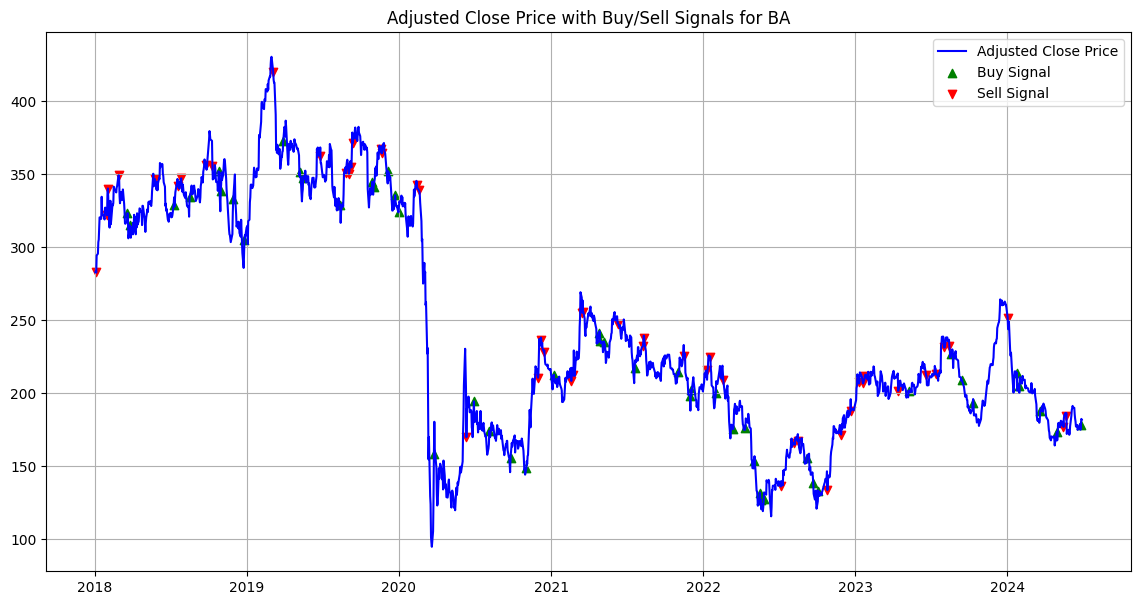

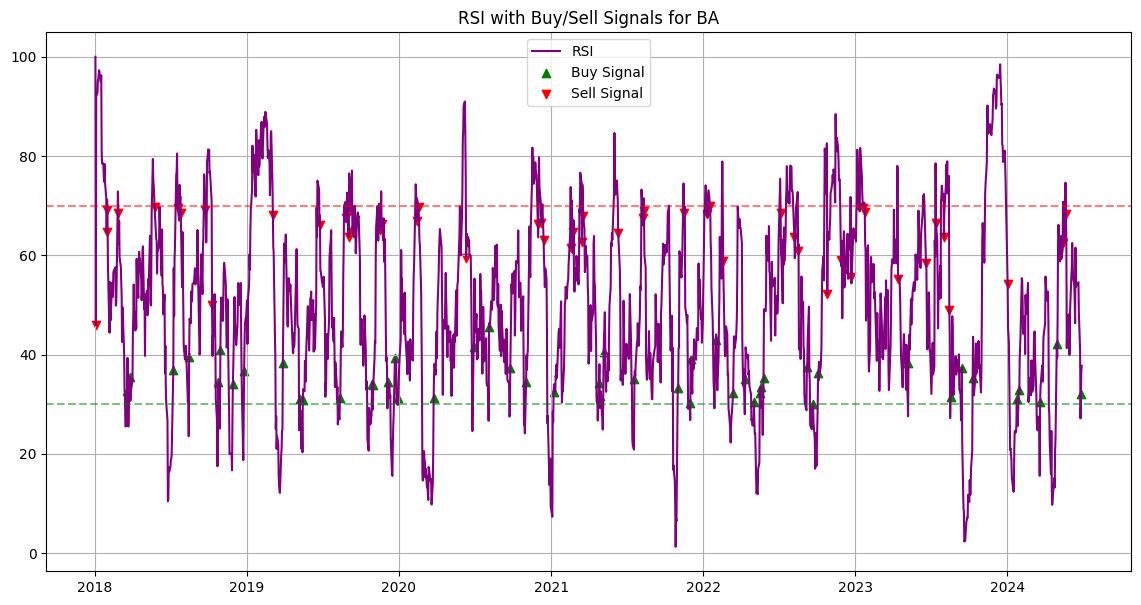

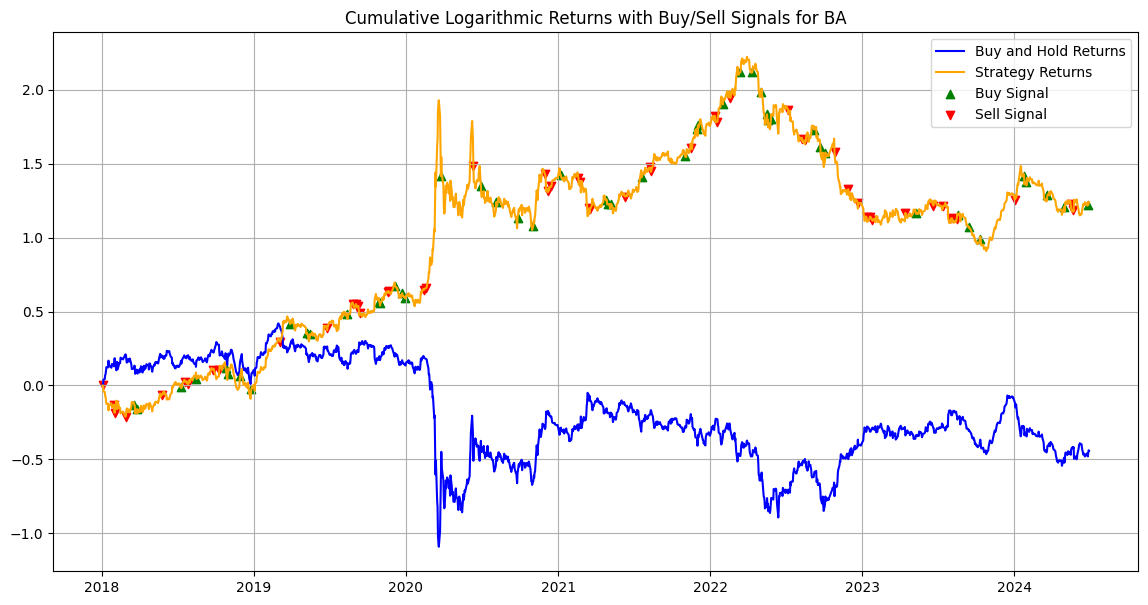

In [29]:
# create a PDF object with the ticker in the filename
pdf_filename = f'RSI_Strategy_Report_{ticker}.pdf'
pdf = PdfPages(pdf_filename)

# add a cover page with the ticker information
plt.figure(figsize=(8.5, 11))
plt.text(0.5, 0.5, f'RSI Strategy Report for {ticker}', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off')
pdf.savefig()
plt.close()

# define markers for buy and sell signals
buy_signals = df.loc[buy_condition, 'Adj Close']
sell_signals = df.loc[sell_condition, 'Adj Close']

# plotting the adjusted close price with buy and sell signals
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Adj Close'], label='Adjusted Close Price', color='blue')

# adding buy signals to the plot
plt.scatter(buy_signals.index, buy_signals, marker='^', color='green', alpha=1, label='Buy Signal')

# adding sell signals to the plot
plt.scatter(sell_signals.index, sell_signals, marker='v', color='red', alpha=1, label='Sell Signal')

plt.title(f'Adjusted Close Price with Buy/Sell Signals for {ticker}')
plt.legend()
plt.grid()
pdf.savefig()
plt.show()

# plotting the RSI with buy and sell signals
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['RSI'], label='RSI', color='purple')
plt.axhline(30, linestyle='--', alpha=0.5, color='green')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')

# adding buy signals to the RSI plot
plt.scatter(buy_signals.index, df.loc[buy_condition, 'RSI'], marker='^', color='green', alpha=1, label='Buy Signal')

# adding sell signals to the RSI plot
plt.scatter(sell_signals.index, df.loc[sell_condition, 'RSI'], marker='v', color='red', alpha=1, label='Sell Signal')

plt.title(f'RSI with Buy/Sell Signals for {ticker}')
plt.legend()
plt.grid()
pdf.savefig()
plt.show()

# cumulative (logarithmic) returns with buy and sell signals
df[['buy and hold returns', 'strat returns']] = df[['buy and hold returns', 'strat returns']].cumsum()
plt.figure(figsize=(14, 7))
plt.plot(df['buy and hold returns'], label='Buy and Hold Returns', color='blue')
plt.plot(df['strat returns'], label='Strategy Returns', color='orange')

# adding buy and sell signals to cumulative returns
plt.scatter(buy_signals.index, df.loc[buy_condition, 'strat returns'], marker='^', color='green', alpha=1, label='Buy Signal')
plt.scatter(sell_signals.index, df.loc[sell_condition, 'strat returns'], marker='v', color='red', alpha=1, label='Sell Signal')

plt.title(f'Cumulative Logarithmic Returns with Buy/Sell Signals for {ticker}')
plt.legend()
plt.grid()
pdf.savefig()
plt.show()


## **VII Analysis**

 We use the pyfolio library for performance and risk analysis of the strategy returns.

Start date,2018-01-02
End date,2024-06-28
Total months,77
,Backtest
Annual return,8.51%
Cumulative returns,69.765%
Annual volatility,47.034%
Sharpe ratio,0.41
Calmar ratio,0.11
Stability,0.23
Max drawdown,-77.448%


Start date,2018-01-02
End date,2024-06-28
Total months,77
,Backtest
Annual return,8.51%
Cumulative returns,69.765%
Annual volatility,47.034%
Sharpe ratio,0.41
Calmar ratio,0.11
Stability,0.23
Max drawdown,-77.448%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,77.45,2020-03-20,2023-10-25,NaT,NaN
1,22.92,2018-10-23,2018-12-24,2019-01-30,72
2,19.88,2018-01-04,2018-02-27,2018-07-16,138
3,16.03,2019-03-22,2019-05-13,2019-08-01,95
4,15.16,2019-12-05,2020-01-22,2020-02-24,58


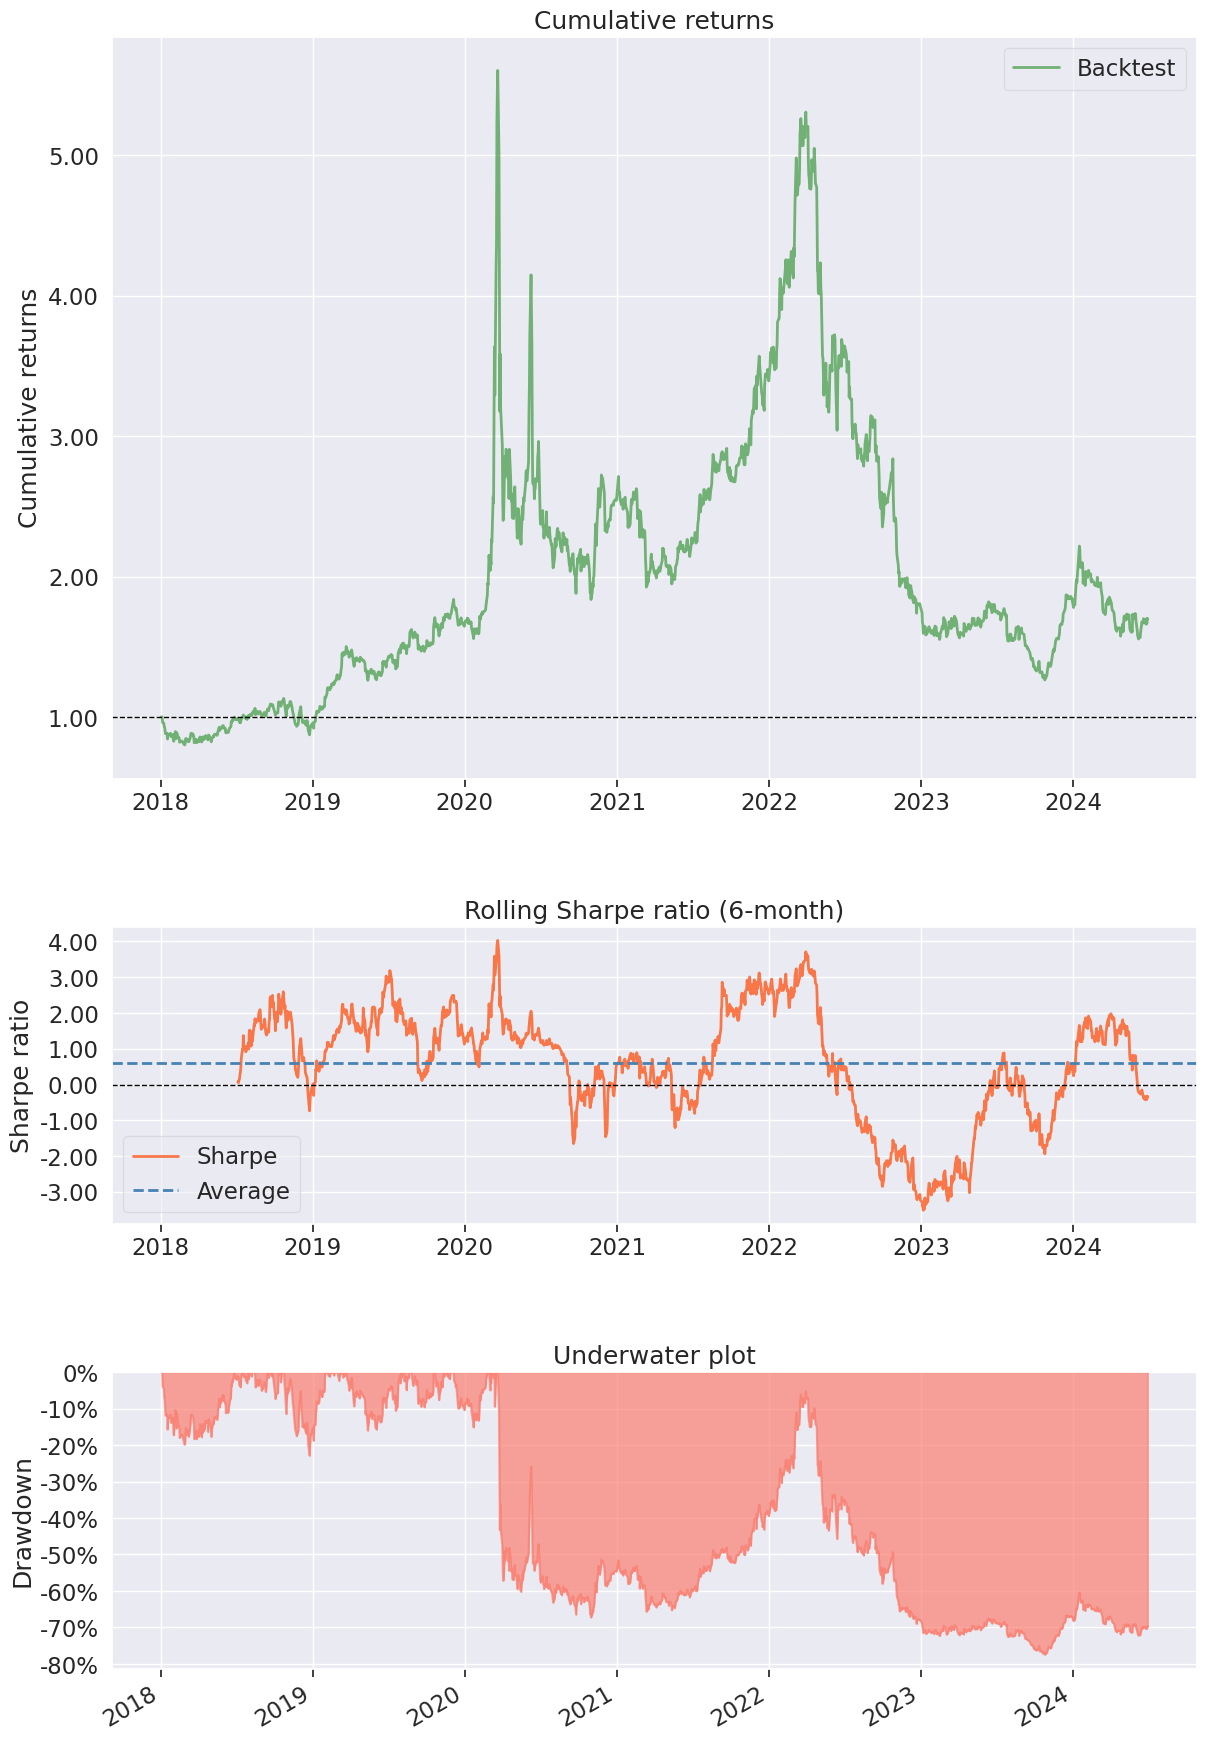

<Figure size 640x480 with 0 Axes>

In [30]:
# %%
pf.create_simple_tear_sheet(df['strat returns'].diff())

# Save pyfolio tear sheet to the PDF
plt.figure()
pf.create_returns_tear_sheet(df['strat returns'].diff())
pdf.savefig()
plt.close()

# close pdf object
pdf.close()


## **Conclusion**

Using the Boeing example, the RSI trading strategy has outperformed the buy and hold returns. Strategy returns looked positively correlated with buy and hold returns as the stock had returns close to 0 and relatively low volatility (2018-early 2020 and 2023-2023). However, strategy returns looked negatively correlated with bnh returns between early 2020 and early 2023, especially as it experienced a sharp decrease on the eve of the COVID-19 pandemic. 

This strategy backtest reports were generated for numerous different stocks and indexes.

**Key Observations:**

The buy-and-hold strategy benefits from long-term appreciation in stock prices, especially during bull markets.
The RSI strategy may underperform during strong trending markets (e.g., Tesla's significant rise from 2019 to 2021) but can outperform during sideways or less volatile markets.

The strategy aims to capture short-term price reversals, potentially generating profits during both upward and downward price movements.

**Possible Applications**

The RSI strategy is suited for active traders seeking to capitalize on short-term price fluctuations, especially in range-bound markets. 
It aids in risk management by identifying overbought and oversold conditions, helping traders avoid unfavorable market entries. 
It can enhance portfolio diversification by providing returns during market consolidations or corrections.